In [1]:
from mimic.utilities import *

from mimic.model_infer.infer_gLV_bayes import *
from mimic.model_infer import *
from mimic.model_simulate import *
from mimic.model_simulate.sim_gLV import *


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as at
import pickle
import cloudpickle

# generalized LV for interactions of 3 microbial species
This project anlyzes three species (S.oneidensis, P.pudita and Synechocystis) interaction in a consortium using informed simulated model and Bayesian analysis to predict the microbial dynanmics in the consortium.

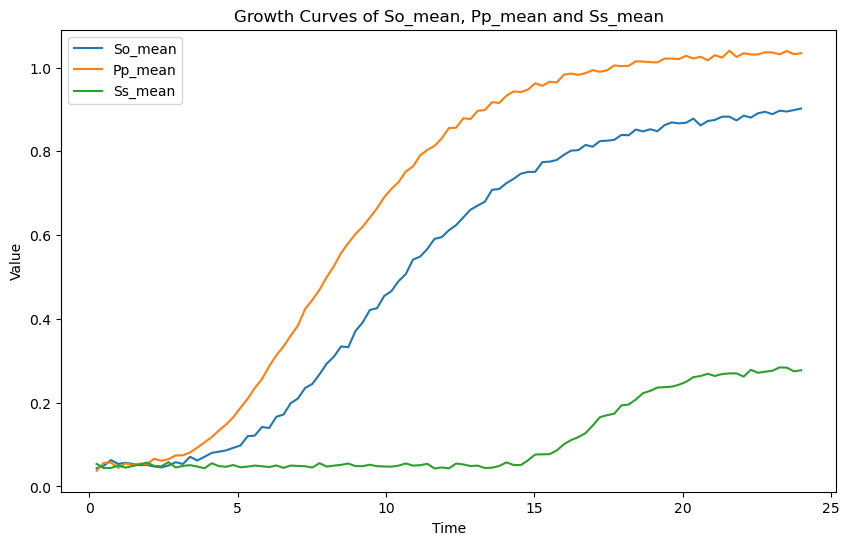

In [ ]:
data = pd.read_csv("simulated_growth_data.csv")
data = data[(0< data['time']) & (data['time'] <= 24.0)]
times = data.iloc[:, 0].values
 
# Plot mean growth curves of each species
species_means = pd.DataFrame({
    "time": data.iloc[:,0],
    "So_mean": data.iloc[:,[1]].mean(axis=1),
    "Pp_mean": data.iloc[:,[2]].mean(axis=1),
    "Ss_mean": data.iloc[:,[3]].mean(axis=1)
})
 
 
# Plot growth curves
plt.figure(figsize=(10, 6))
plt.plot(species_means['time'], species_means['So_mean'], label='So_mean')
plt.plot(species_means['time'], species_means['Pp_mean'], label='Pp_mean')
plt.plot(species_means['time'], species_means['Ss_mean'], label='Ss_mean')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Growth Curves of So_mean, Pp_mean and Ss_mean')
plt.legend()
plt.show()

In [ ]:
# Extract data and convert to numpyarrays

yobsdf = species_means.iloc[:, 1:4]
yobs = yobsdf.to_numpy()
#timesa = sim_data.iloc[:, 0]
#times = timesa.to_numpy()

In [ ]:
X, F = linearize_time_course_16S(yobs, times)

In [ ]:
# Perform Bayesian inference without shrinkage

# Define priors
prior_mu_mean = 0.15
prior_mu_sigma = 1

## NB prior_Mii_mean is 0, so not defined as an argument
# prior_Mii_mean =  0.1
# prior_Mii_sigma = 0.1

# prior_Mij_sigma = 0.1

prior_Mii_mean = 0.1       # Mean of diagonal elements
prior_Mii_sigma = 0.5      # Increased variance to allow flexibility
prior_Mij_sigma = 0.5      # Non-diagonal interaction variability


# Sampling conditions
draws = 500
tune = 500
chains = 4
cores = 4

inference = infergLVbayes()

inference.set_parameters(X=X, F=F, prior_mu_mean=prior_mu_mean, prior_mu_sigma=prior_mu_sigma,
                          prior_Mii_sigma=prior_Mii_sigma, prior_Mii_mean=prior_Mii_mean,
                          prior_Mij_sigma=prior_Mij_sigma,
                          draws=draws, tune=tune, chains=chains,cores=cores)

idata = inference.run_inference()


X shape: (98, 4)
F shape: (98, 3)
Number of species: 3
AdvancedSetSubtensor.0


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu_hat, M_ii_hat_p, M_ij_hat]


Output()

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 30 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


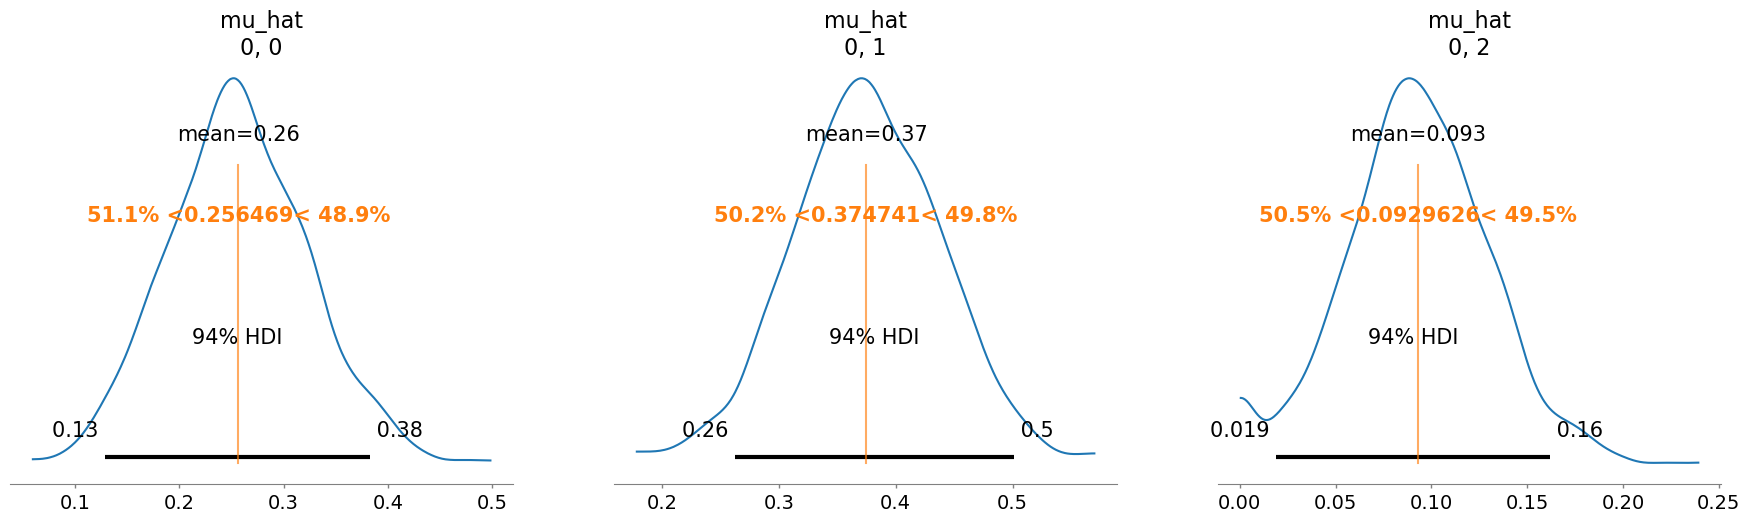

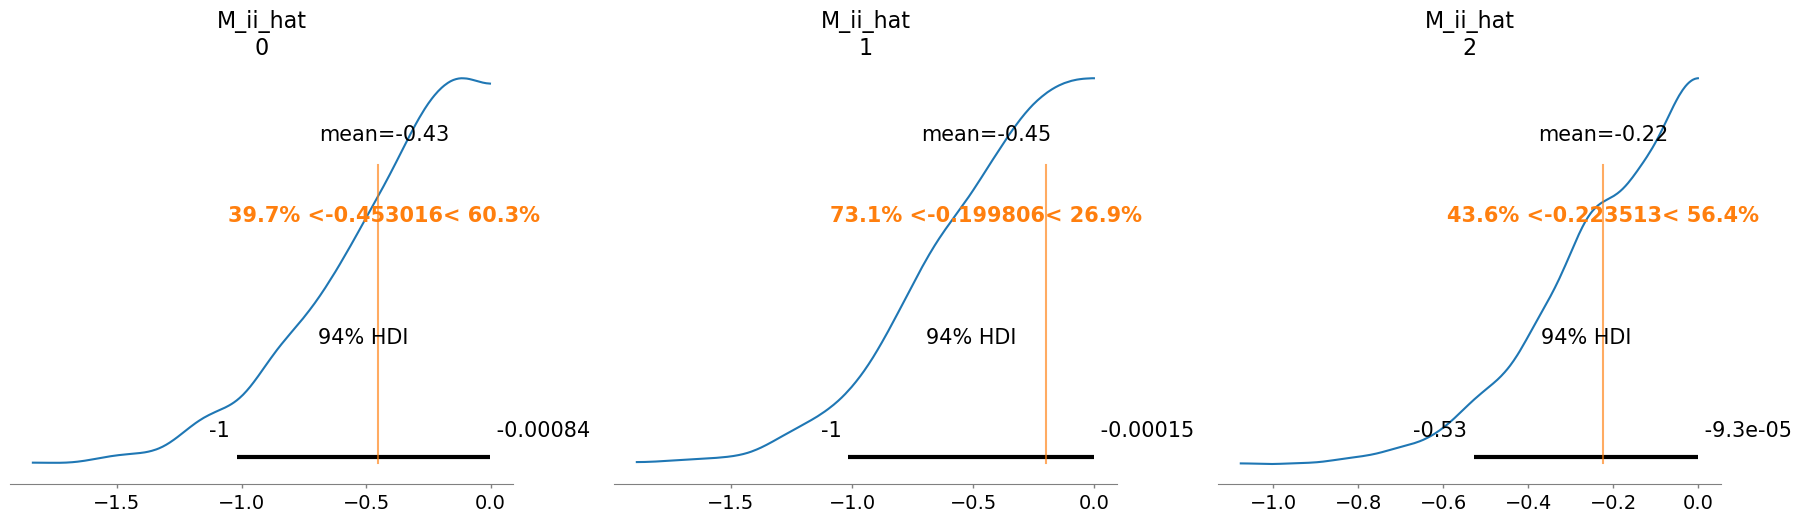

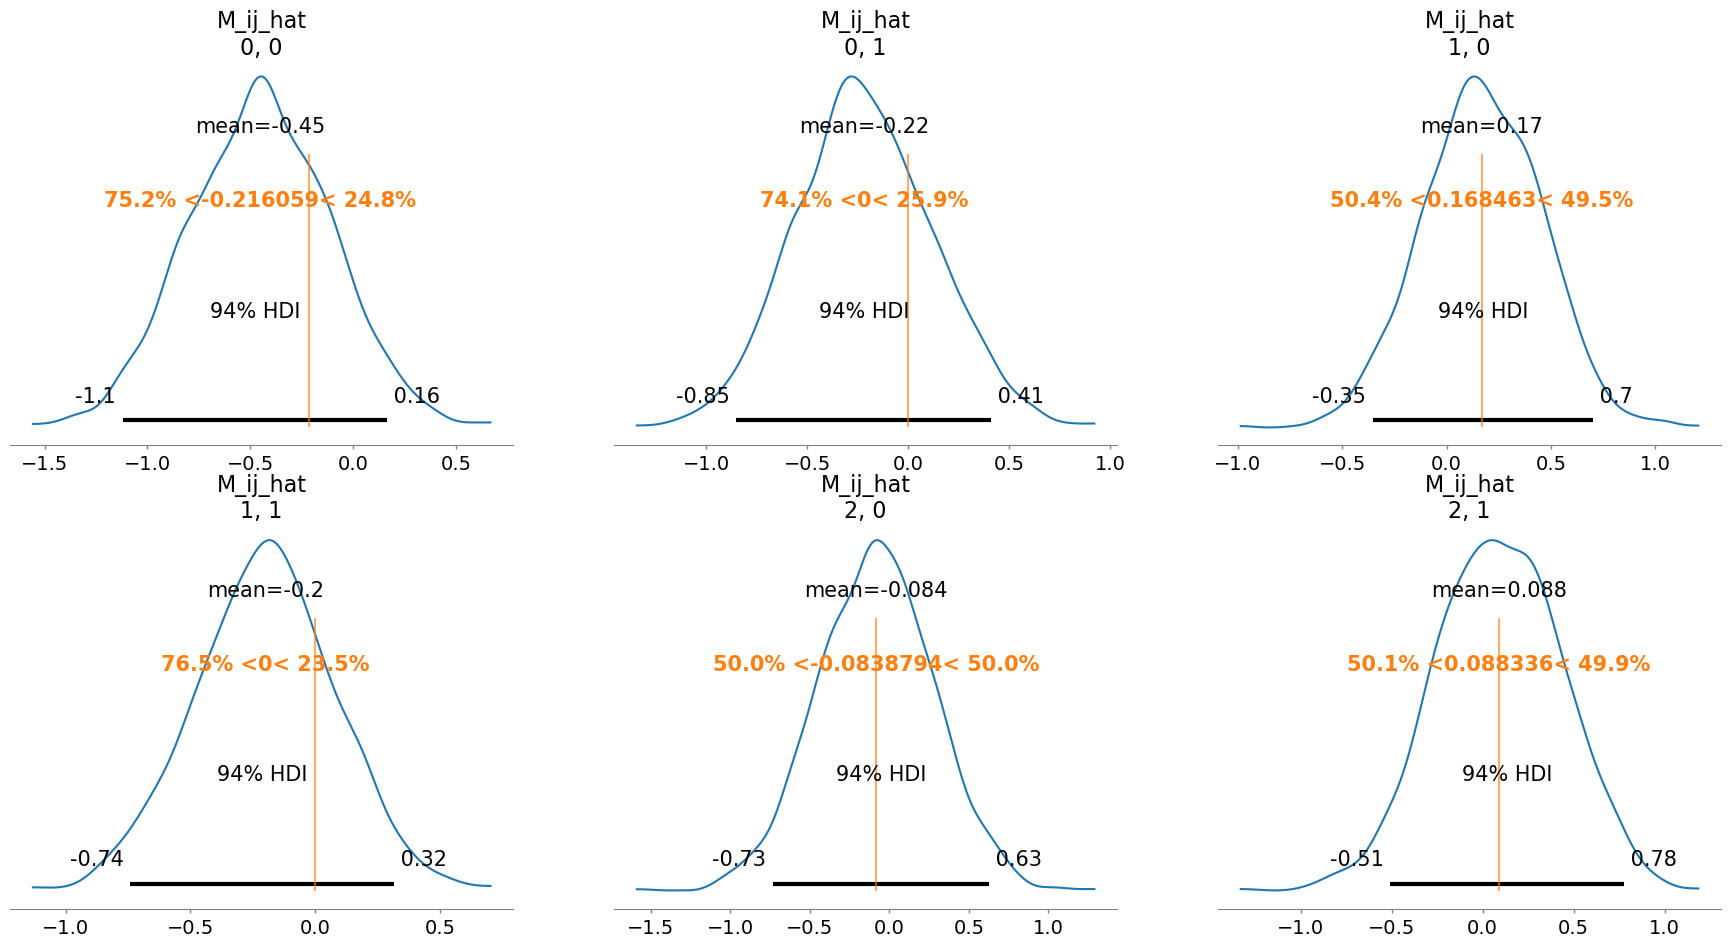

In [ ]:
# To plot posterior distributions
inference.plot_posterior(idata)

c:\Users\miran\anaconda3\envs\mimic_env\lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
c:\Users\miran\anaconda3\envs\mimic_env\lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


                 mean     sd  r_hat
mu_hat[0, 0]    0.256  0.067   1.01
mu_hat[0, 1]    0.375  0.064   1.00
mu_hat[0, 2]    0.093  0.037   1.01
M_ii_hat[0]    -0.426  0.321   1.00
M_ii_hat[1]    -0.445  0.327   1.00
M_ii_hat[2]    -0.224  0.172   1.00
M_ij_hat[0, 0] -0.453  0.344   1.00
M_ij_hat[0, 1] -0.216  0.340   1.00
M_ij_hat[1, 0]  0.168  0.285   1.00
M_ij_hat[1, 1] -0.200  0.281   1.00
M_ij_hat[2, 0] -0.084  0.366   1.00
M_ij_hat[2, 1]  0.088  0.348   1.01
M_hat[0, 0]    -0.453  0.344   1.00
M_hat[0, 1]    -0.216  0.340   1.00
M_hat[0, 2]     0.000  0.000    NaN
M_hat[1, 0]     0.168  0.285   1.00
M_hat[1, 1]    -0.200  0.281   1.00
M_hat[1, 2]     0.000  0.000    NaN
M_hat[2, 0]    -0.084  0.366   1.00
M_hat[2, 1]     0.088  0.348   1.01
M_hat[2, 2]    -0.224  0.172   1.00
sigma[0]        0.307  0.013   1.00


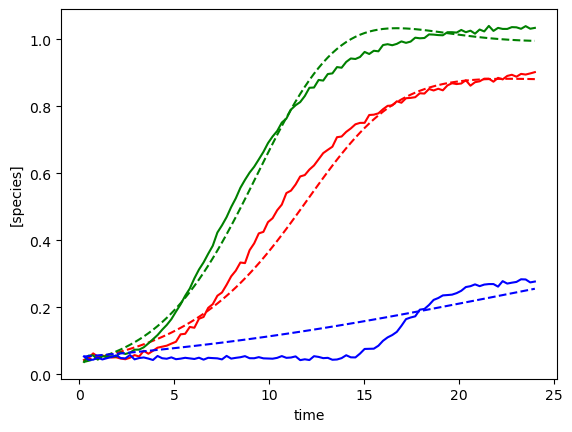

In [ ]:
num_species = 3

# Print summary
summary = az.summary(idata, var_names=["mu_hat", "M_ii_hat", "M_ij_hat", "M_hat", "sigma"])
print(summary[["mean", "sd", "r_hat"]])
 
 
# Save posterior samples to file
az.to_netcdf(idata, 'model_posterior.nc')
 
# get median mu_hat and M_hat
mu_h = np.median(idata.posterior["mu_hat"].values, axis=(0,1) ).reshape(-1)
M_h = np.median(idata.posterior["M_hat"].values, axis=(0,1) )
 
# compare fitted with simulated parameters
 
predictor = sim_gLV(num_species=num_species, M=M_h.T, mu=mu_h)
yobs_h, _, _, _, _ = predictor.simulate(times=times, init_species=yobs[0])
plot_fit_gLV(yobs, yobs_h, times)